In [1]:
%matplotlib inline
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2

###############################################################################
# 1. Gabor filter creation and convolution
###############################################################################
def gabor_kernel(ksize, sigma, theta, lambd, gamma=1.0, psi=0.0):
    """
    Create a complex Gabor kernel (2D) of shape (ksize, ksize).
    """
    half = ksize // 2
    y, x = np.meshgrid(
        np.arange(-half, half + 1),
        np.arange(-half, half + 1),
        indexing='xy'
    )
    # Rotate coords
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # Gaussian envelope
    gauss = np.exp(-0.5 * ((x_theta**2 + gamma**2 * y_theta**2) / (sigma**2)))

    # Sinusoidal carrier
    real_part = gauss * np.cos((2 * np.pi * x_theta / lambd) + psi)
    imag_part = gauss * np.sin((2 * np.pi * x_theta / lambd) + psi)

    return real_part + 1j * imag_part

def gabor_convolution(image, kernel):
    """
    Convolve an image with a complex Gabor kernel:
    - filter2D with real part
    - filter2D with imaginary part
    - combine into a complex result
    """
    real_response = cv2.filter2D(image, cv2.CV_64F, kernel.real)
    imag_response = cv2.filter2D(image, cv2.CV_64F, kernel.imag)
    return real_response + 1j * imag_response

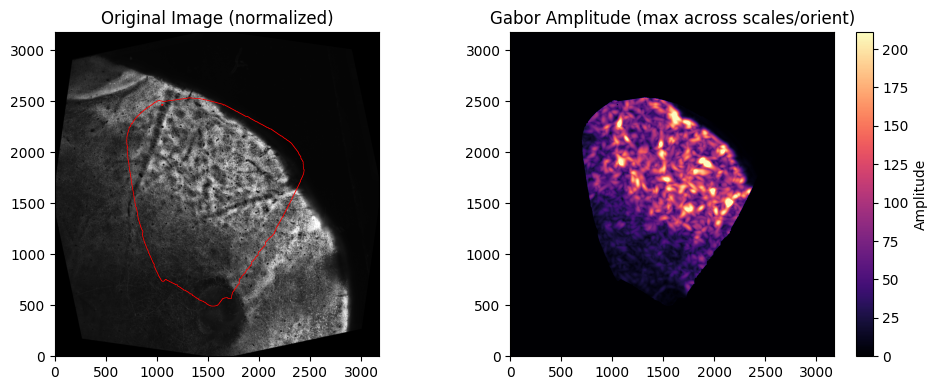

In [6]:
###############################################################################
# 2. Main routine: load image & mask, apply Gabor, build amplitude map
###############################################################################

# --------------------------
# A) Load the image
# --------------------------
img_path = "RSC_118.tif"   # your image file
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Cannot find {img_path}")

# Read single channel (if your TIFF has multiple channels, pick one)
image = tifffile.imread(img_path)
# If shape is (H,W) -> single channel. If (C,H,W), pick a channel like image[0,...].
if len(image.shape) == 3:
    # Suppose you want the first channel
    image = image[0,...]
image = image.astype(np.float32)

# Normalize to [0,1]
image = (image - image.min()) / (image.max() - image.min() + 1e-12)

# --------------------------
# B) Load the ROI mask
# --------------------------
mask_path = "Mask_118.tif" # your mask file
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Cannot find {mask_path}")

mask = tifffile.imread(mask_path).astype(bool)
if mask.shape != image.shape:
    raise ValueError("Mask shape does not match image shape!")

# --------------------------
# C) Define Gabor parameters
# --------------------------
"""
Gabor Parameters

ksize: Size of the filter in pixels (must be odd).
sigma_list: The Gaussian width(s) you want to try (larger = captures lower frequency / bigger features).
theta_list: Orientations in radians. (0, 45°, 90°, 135°, etc.)
lambd = sigma * lambd_ratio: Wavelength of the sinusoid.
gamma = 1.0: Circular envelope.
psi = 0.0: Phase offset of the sinusoid.
"""

ksize = 193       # filter size, must be odd, bigger -> more context
sigma_list = [8, 16, 24]  # or [16,24,32], etc. 
theta_list = [0, np.pi/4, np.pi/2, 3*np.pi/4]
lambd_ratio = 2.0
gamma = 1.0
psi = 0.0

# We'll build a final amplitude map that is
# the maximum amplitude across all scales/orientations.
# (You can also sum them or do something else.)
H, W = image.shape
amplitude_map = np.zeros((H, W), dtype=np.float32)

# --------------------------
# D) Apply Gabor filters
# --------------------------
for sigma in sigma_list:
    lambd = sigma * lambd_ratio
    for theta in theta_list:
        # Create Gabor kernel
        kernel = gabor_kernel(ksize, sigma, theta, lambd, gamma, psi)
        # Convolve
        response = gabor_convolution(image, kernel)
        # Compute amplitude
        amplitude = np.abs(response)
        # Update amplitude_map with the max
        amplitude_map = np.maximum(amplitude_map, amplitude)

# --------------------------
# E) Mask the result
# --------------------------
# We only care about the region inside the mask; set outside to 0
amplitude_map_masked = np.zeros_like(amplitude_map)
amplitude_map_masked[mask] = amplitude_map[mask]

# --------------------------
# F) Display or save result
# --------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original Image (normalized)")
plt.imshow(image, cmap='gray', origin='lower')
plt.contour(mask, colors='r', linewidths=0.5)  # show ROI outline

plt.subplot(1,2,2)
plt.title("Gabor Amplitude (max across scales/orient)")
# Clip the colormap range for better visibility
vmax_val = np.percentile(amplitude_map_masked[mask], 99)
plt.imshow(amplitude_map_masked, cmap='magma', origin='lower', vmax=vmax_val)
plt.colorbar(label="Amplitude")

plt.tight_layout()
plt.show()

# If you want to save the amplitude map to a TIFF:
# tifffile.imwrite("gabor_amplitude_map.tif", amplitude_map_masked, dtype=np.float32)